# Auxiliary tutorial 7: Support vector machines

(c) 2016 Porfirio Quintero and Junedh Amrute. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This lesson was generated from an Jupyter notebook.  You can download the notebook [here](aux7_SVMs.ipynb). You can also view it [here](https://nbviewer.jupyter.org/url/bebi103.caltech.edu/2016/tutorials/aux7_SVMs.ipynb).*

## Introduction

To understand the use of support vector machines consider a simple example. We want to decide whether an individual receives credit from a bank. Whether the individual gets credit or not will be determined by a large number of factors such as salary, debt history, credit worthiness, liquidity, etc. So, let's formulate the problem: we have a $d$ dimensional input vector for a dataset, which coressponds to all the features mentioned previously which will affect whether the individual gets credit approval, we have a target function $f$, which is the exact "calculator" of credit, and we have a binary output of $\pm 1$: credit or no credit. Our goal is to use the data provided $(\textbf{x}, y)$, to develop a model $g(\textbf{x})$ which can approximate the target function $f(\textbf{x})$ well. We can then use inputs $\textbf{x}$ outside the dataset to determine whether a particular individual gets credit or not. This problem is referred to as a classification problem, where we are classifying the data into two regions (credit or no credit). 

A SVM can either be linear and parametric or non-linear and non-parametric. The latter is more complicated and requires the use of a kernel. Below, I will focus on linear and parametric SVM's where the hypothesis function is linear and parametric.

<img src='aux7_SVMs_fig1.png'>

The above image (accessed [here](https://commons.wikimedia.org/wiki/File:Kernel_Machine.svg) and used under the copyright contained therein) shows a simple classification where we have a linear model separating the blue and orange regions. However, you can notice that more than one line can be used to obtain the above classification. Now, lets define a few terms: $E_{in}$ and $E_{out}$ are the in sample and out of sample errors respectively. $E_{in}$ is the fraction of misclassified points from the training dataset. $E_{out}$ is the fraction of misclassified points from the new data set, which is out of sample (since it is not used to train our model). Our goal is to use $E_{in}$ as a proxy for $E_{out}$ and ultimately minimize $E_{out}$. In the above figure, using various lines that obtained the same classification would still have the same $E_{in}$, but different $E_{out}$'s. Consequently, the choice of line is crucial. The range of potential lines that we can used is called the margin. See [this figure from the OpenCV tutorial](http://docs.opencv.org/2.4/doc/tutorials/ml/introduction_to_svm/introduction_to_svm.html) (which we cannot include here for copyright reasons). From that figure, we see that we have a maximum margin within which the optimal plane can lie and there is a maximal, which is in the middle of this margin. Now, we have $2$ questions:

1. Why is a bigger margin better?
2. Find a function, which maximizes the margin

A dichotomy is defined as the number of different lines which yield a different classification. Hence, 2 different lines which have the same classification come under the same dichotomy. If the margin is very large then we will have fewer dichotomies. This is good because the larger the number of dichotomies the worse $E_{in}$ can track $E_{out}$ (I will not prove this fact here). But please refer to growth functions and the Hoeffding inequality. The point to understand is that a large margin means that it is easier to approximate the out of sample error using the in sample error. In other words, for a large margin (and hence fewer dichotomies), the probability that $E_{in}$ and $E_{out}$ differ by some $\epsilon$ is smaller. This is good news because it means that our model generalizes well; if $E_{in}$ tracks $E_{out}$ well then we can be sure that when we minimize $E_{in}$, we are also going to have a small $E_{out}$, which is the point of machine learning!

Let the equation of the separating plane be $\textbf{w}^T\textbf{x}_n + b = 0$. Now because $k(\textbf{w}^T\textbf{x}_n + b) = 0$, we have the choice to pick any normalization. Pick a normalization such that $\textbf{w}^T\textbf{x}_+ + b = 1$ and $\textbf{w}^T\textbf{x}_- + b = -1$ for the positive and negative support vectors respectively. From the figure below we can see that the size of the margin is $\frac{2}{\| \textbf{w} \|}$.

<img src='aux7_SVMs_fig3.png' style="width:500px">

Now, we want to maximize the margin with our normalization constraint, hence the optimization problem becomes

\begin{align}
&\mbox{maximize } \frac{2}{\| \textbf{w} \|}\\[1em]
&\mbox{subject to } \min_{n = 1, 2, .., N}\mbox{ }|\textbf{w}^T\textbf{x}_n + b| = 1
\end{align}

This problem is equivalent to the following optimization problem:

\begin{align}
&\mbox{minimize } \frac{1}{2}\textbf{w}^T\textbf{w}\\[1em]
&\mbox{subject to } y_n(\textbf{w}^Tx_n + b) \geq 1 \mbox{ for } n = 1, 2, ..., N
\end{align}

## Application example: face recognition with SVMs

Now we will train an SVM classifier to recognize faces. We will use images from [Labeled Faces in the Wild](http://vis-www.cs.umass.edu/lfw/), a huge database of labeled face photographs that is available through the sklearn.datasets module. The example is based on [this script](http://scikit-learn.org/stable/auto_examples/applications/face_recognition.html) from the sklearn documentation.

As usual, we first import everything we will use.

In [1]:
import numpy as np

from sklearn import model_selection
from sklearn.datasets import fetch_lfw_people
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.utils.extmath import fast_dot

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)
%matplotlib inline

Let's get started and fetch some photographs. To get a decent predictive power, we will only use those of people for which there are at least 50 pictures available.

In [2]:
# fetch photographs from the LFW dataset
lfw_people = fetch_lfw_people(min_faces_per_person=50)

# get number of pictures and dimensions
n_samples, h, w = lfw_people.images.shape

# get the names of people in the picture, in case we can't recognize them...
names = lfw_people.target_names
n_people = names.shape[0]

Let's see how many people and pictures we found that meet our requirement.

In [3]:
print("""
    There are {0} people with more than 50 pictures, 
    and a total of {1} photographs.
    Each one is a grayscale image of {2} by {3} pixels.
    """.format(n_people, n_samples, h, w))


    There are 12 people with more than 50 pictures, 
    and a total of 1560 photographs.
    Each one is a grayscale image of 62 by 47 pixels.
    


Since we will be looking at several pictures throughout the tutorial, we will define a function to plot a gallery of pictures.

In [4]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=4, fig_title=None):
    """
    Helper function to plot a gallery of portraits
    """
    fig = plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        ax = fig.add_subplot(n_row, n_col, i + 1)
        ax.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        ax.set_title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
    if fig_title: fig.suptitle(fig_title+'\n', fontsize=20)

Now we can take a look at one picture of each person and see if we can recognize anyone.

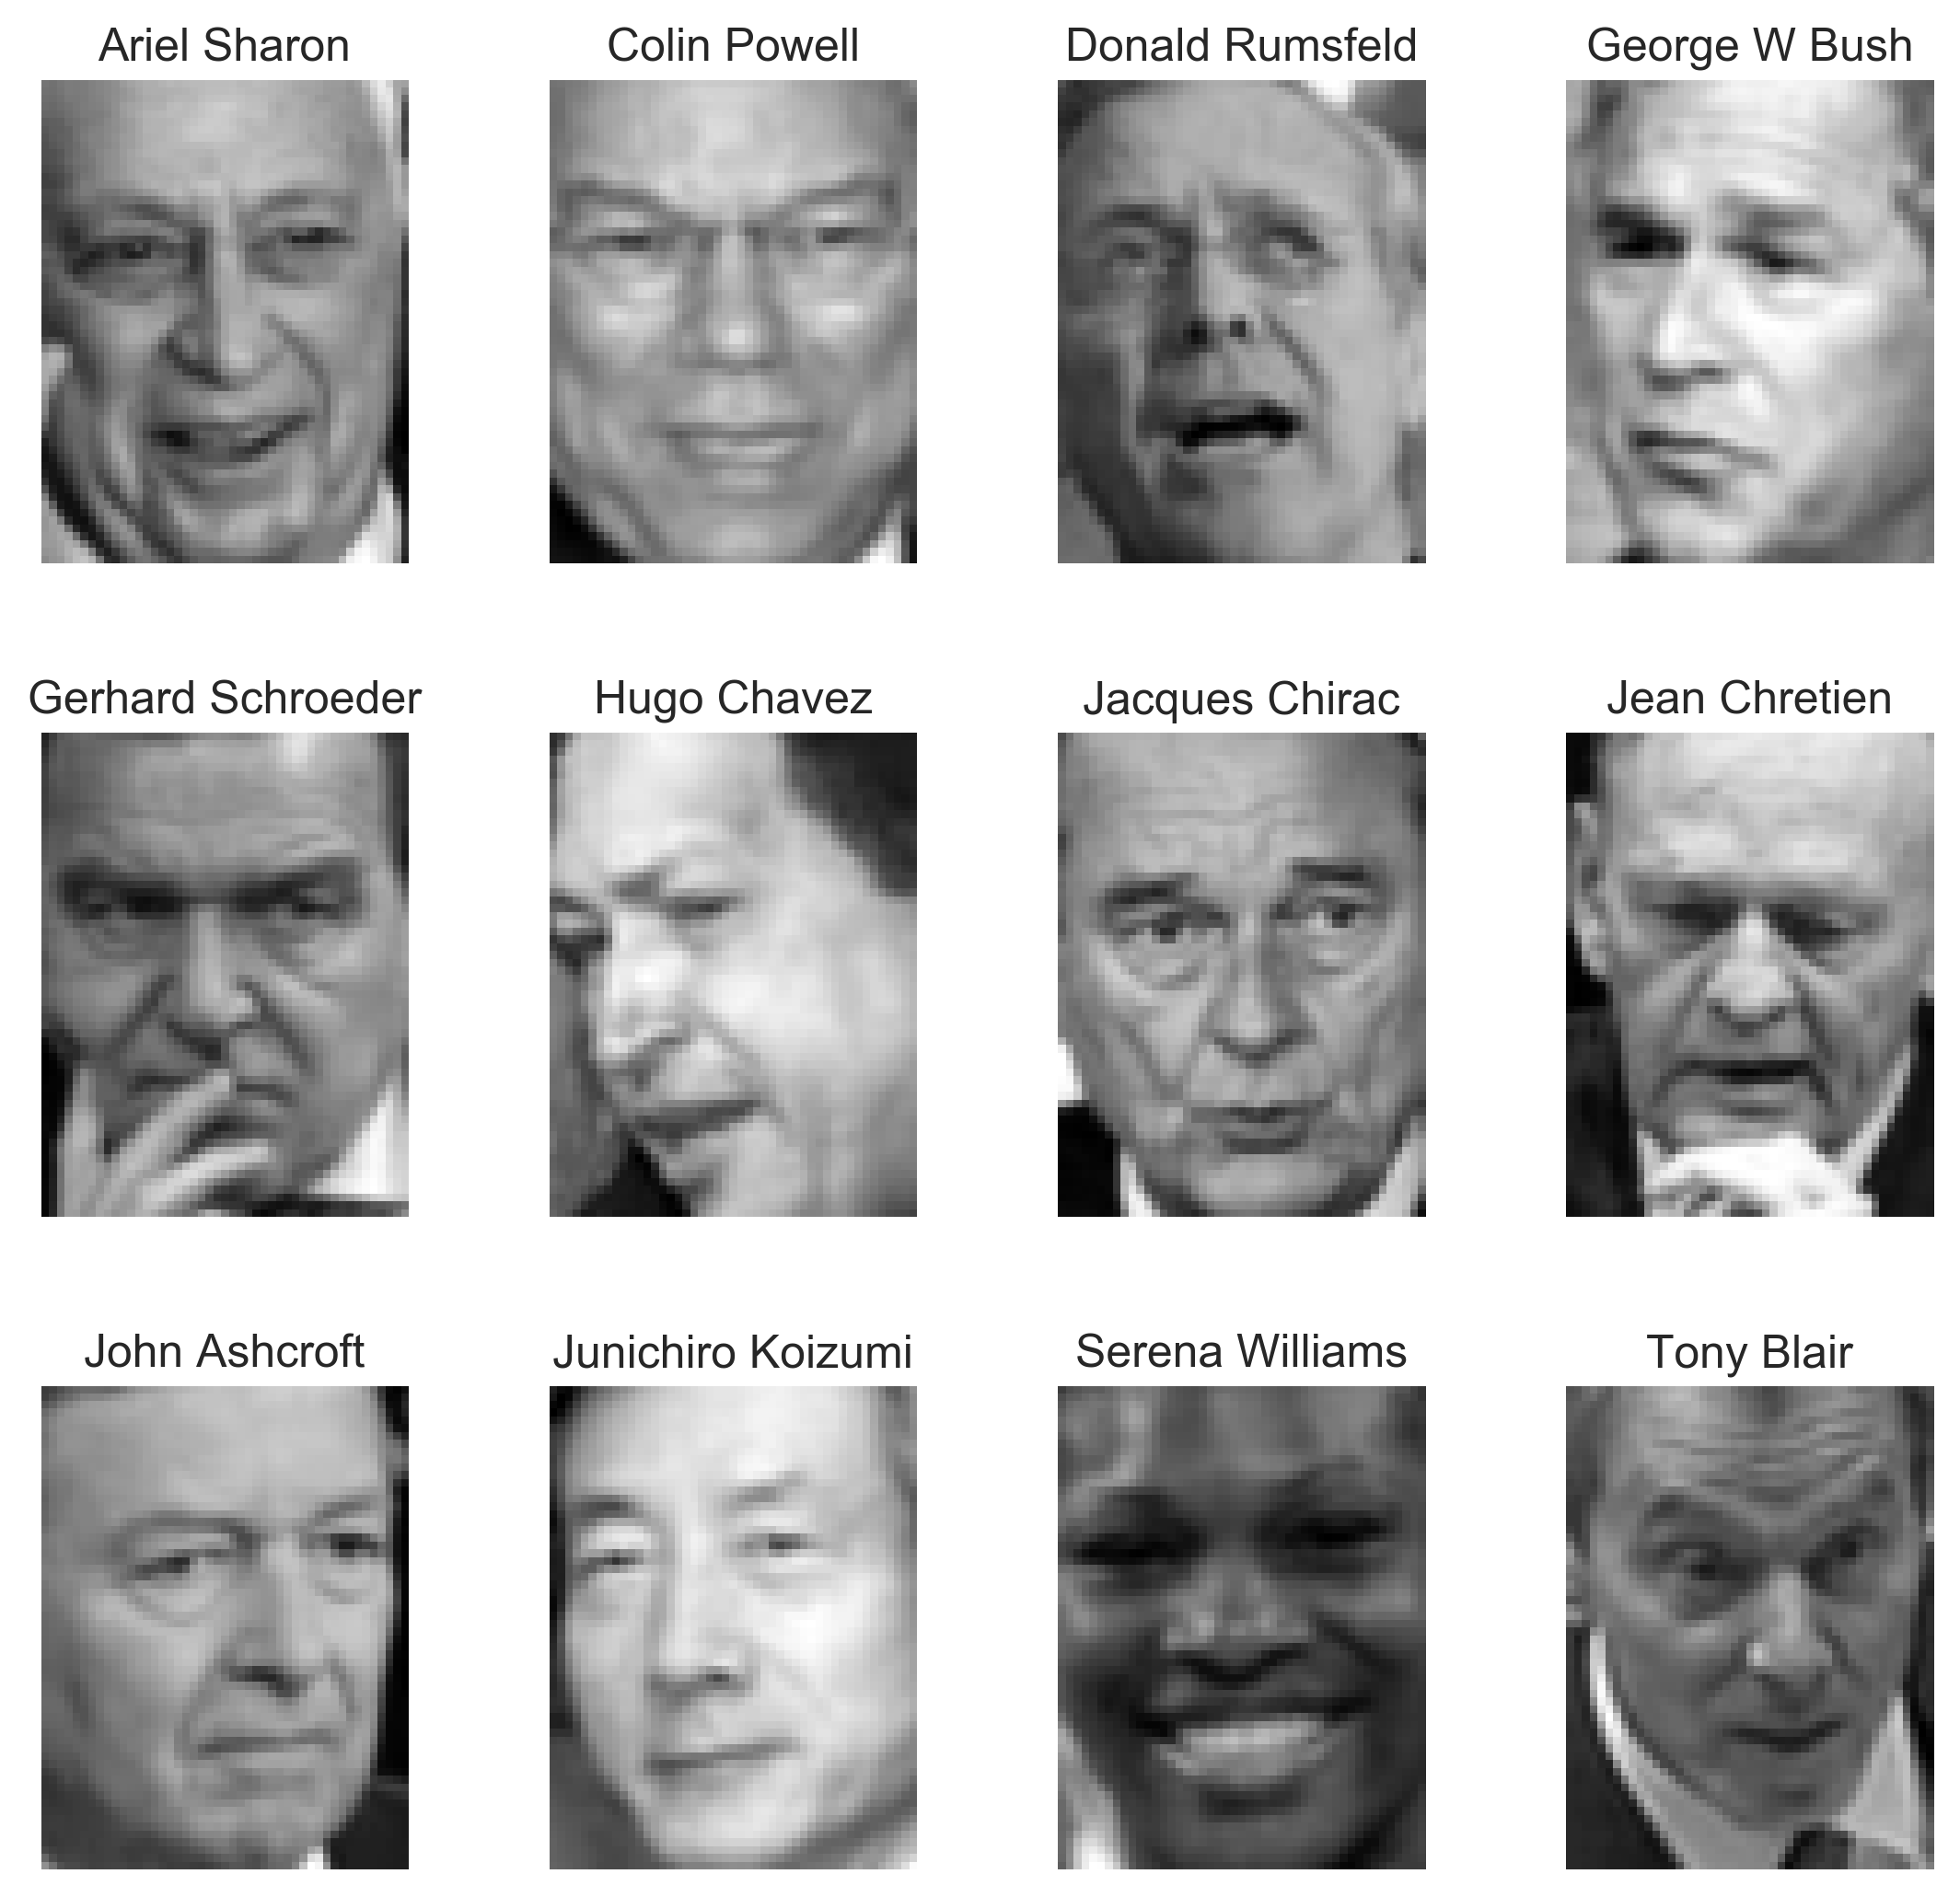

In [5]:
# get the index of one picture of each person
unique_pic = [np.where(lfw_people.target==n)[0][0] for n in np.arange(12)]

# look at them
plot_gallery(lfw_people.images[unique_pic], names, h, w)

Mostly politicians, all  with Wikipedia pages if you'd like to know who they are.

We will ignore relative pixel position and treat each photograph as a $62 \times 47 = 2914$ dimensional datapoint. So we need to get our data into a 2914 dimensional array, instead of the 62 by 47 pixels that we have. We can access data in this form directly from the loader, so we will just do that.

In [6]:
# get images as n dimensional array
photos = lfw_people.data
print("""
    There are still {0} images, now each represented 
    as a {1}-dimensional array.
    """.format(*photos.shape))


    There are still 1560 images, now each represented 
    as a 2914-dimensional array.
    


Also, we are trying to use SVM for face recognition, so we need to split our data into a training and a test set so that we can evaluate our ability to correctly recognize faces. We will use sklearn's handy train_test_split function for this.

In [7]:
# get the labels of each photograph
labels = lfw_people.target

# split into a training and testing set
photos_train, photos_test, labels_train, labels_test = \
    model_selection.train_test_split(photos, labels, test_size=0.25, 
                                     random_state=42)
print("""
    Our training and test datasets have
    {0} and {1} photographs, respectively.
    """.format(photos_train.shape[0], photos_test.shape[0]))


    Our training and test datasets have
    1170 and 390 photographs, respectively.
    


Training an SVM using data points of 2914 dimensions will probably take a while. However all human faces are somewhat similar, so we probably don't need all those dimensions. What can we do to get rid of features that would not contribute very much to tell faces apart? i.e. how do we reduce the number of dimensions while preserving the variance? A pretty good answer is: principal component analysis. You can read the [excellent tutorial](http://bebi103.caltech.edu/2016/tutorials/aux4_pca.html) about PCA if you haven't yet. So let's get rid of some dimensions; we will start with 10% of the original number and figure out how many we need.

In [8]:
# 10% of the dimensions
n_components = int(photos.shape[1] * 0.1)

# apply dimensionality reduction
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(photos_train)

We can tell how much each new feature contributes to making the photographs different by computing their explained variance ratio. We can also get an idea of how many dimensions we need by looking at at the cumulative explained variance as we increase the number of dimensions/features. Let's do that.

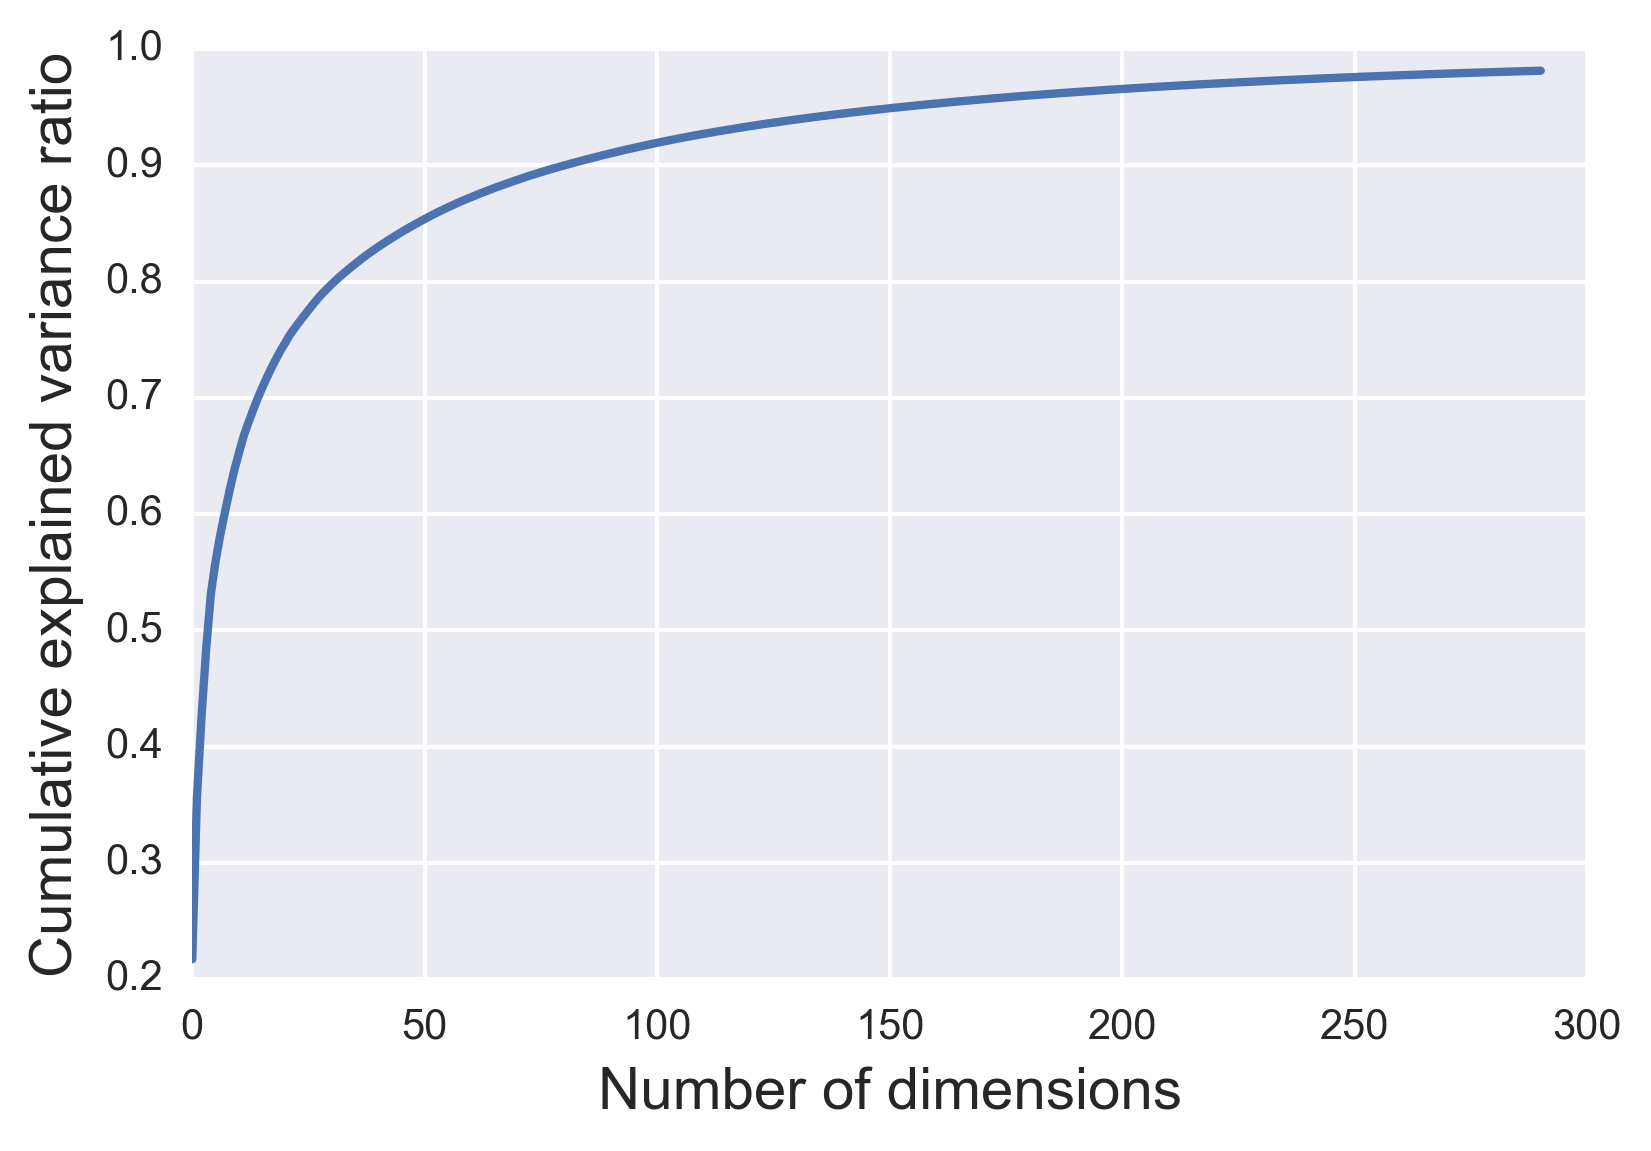

In [9]:
# compute cumulative sum of explained variance ratios
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

# look at it
plt.plot(cum_exp_var)
plt.xlabel('Number of dimensions')
plt.ylabel('Cumulative explained variance ratio')
plt.xlim(0,300);

It seems like indeed we don't need that many dimensions. For speed, we'll go with 50 for now, which should get us about 80% of the variance.

In [10]:
n_components = 50

# apply dimensionality reduction
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(photos_train)
cum_exp_var = np.cumsum(pca.explained_variance_ratio_)

print("""
    {0} features explain {1:.2f}% of the variance.
    """.format(n_components, cum_exp_var[-1]*100))

# Project the data to the lower dimensional planes
photos_train_pca = pca.transform(photos_train)
photos_test_pca = pca.transform(photos_test)


    50 features explain 85.15% of the variance.
    


We can plot a slice of our transformed data to get a sense of what they are now. Note that the x-axis has no meaning; we are just plotting each of the new dimensions of our datapoints as an $x,y$ pair, where $y$ is the dimensional value and $x$ is just a meaningless dimension number.


    We still have 1170 datapoints in our training set, 
    now each represented as a 50-dimensional array.
    


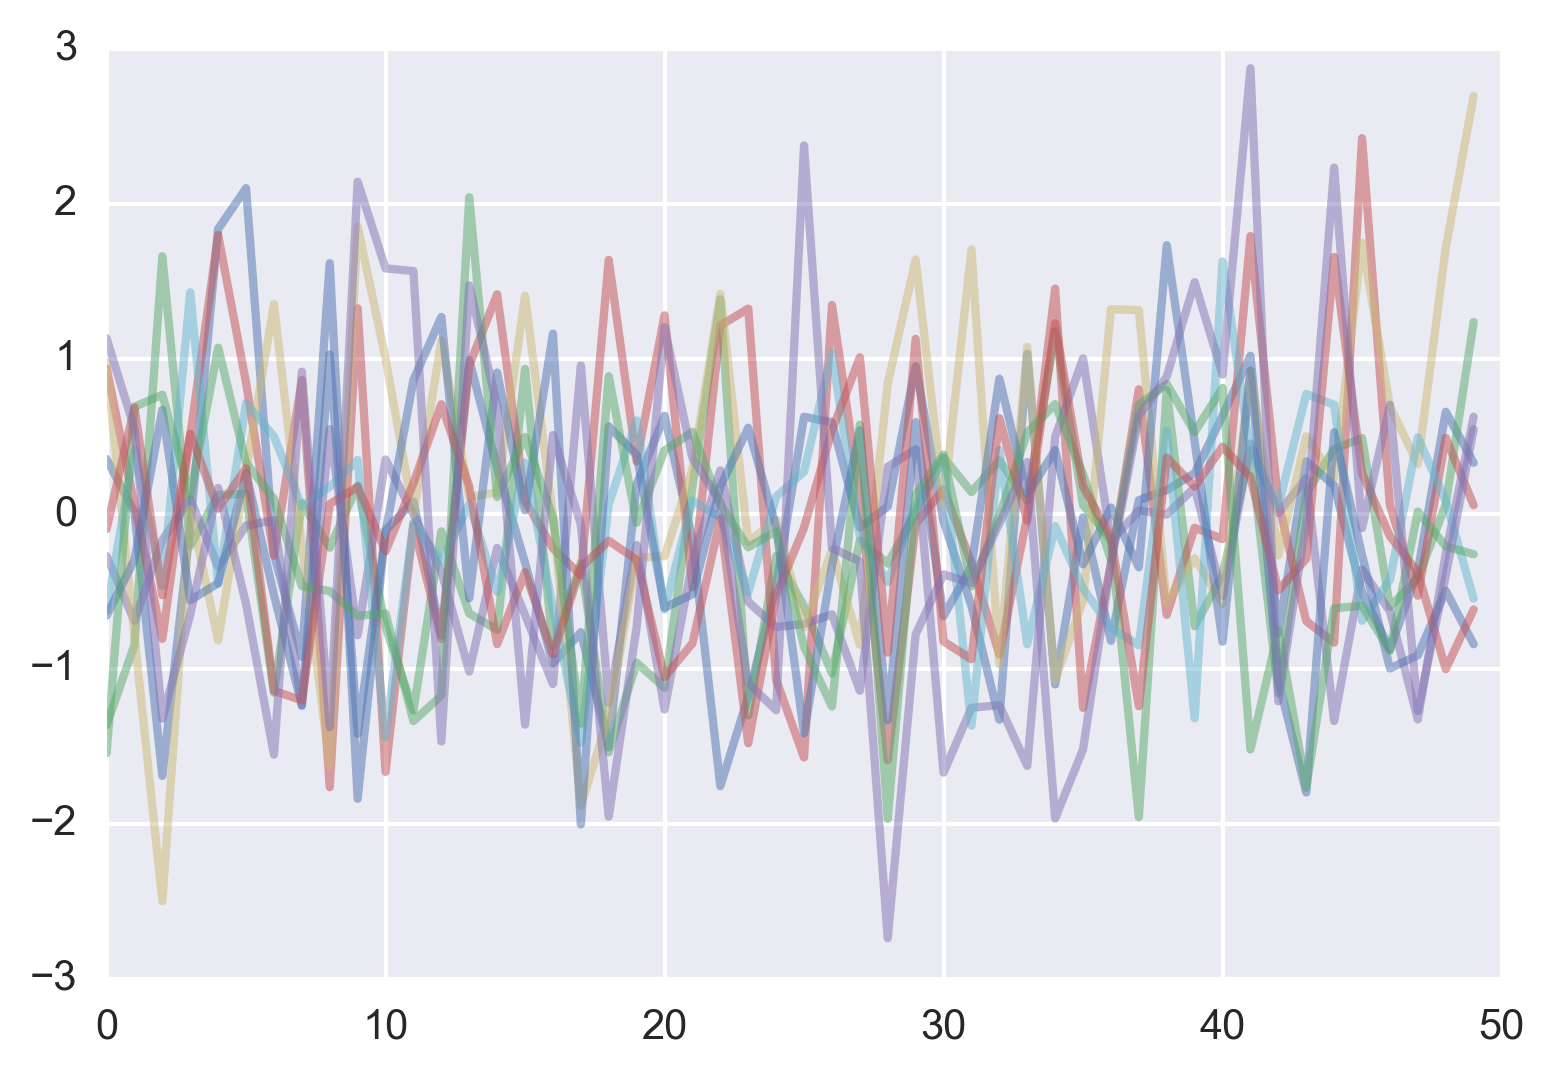

In [11]:
plt.plot(photos_test_pca[:10].transpose(), alpha=0.5);

print("""
    We still have {0} datapoints in our training set, 
    now each represented as a {1}-dimensional array.
    """.format(*photos_train_pca.shape))

We can also see what the principal components look like by reshaping them back into photographs.

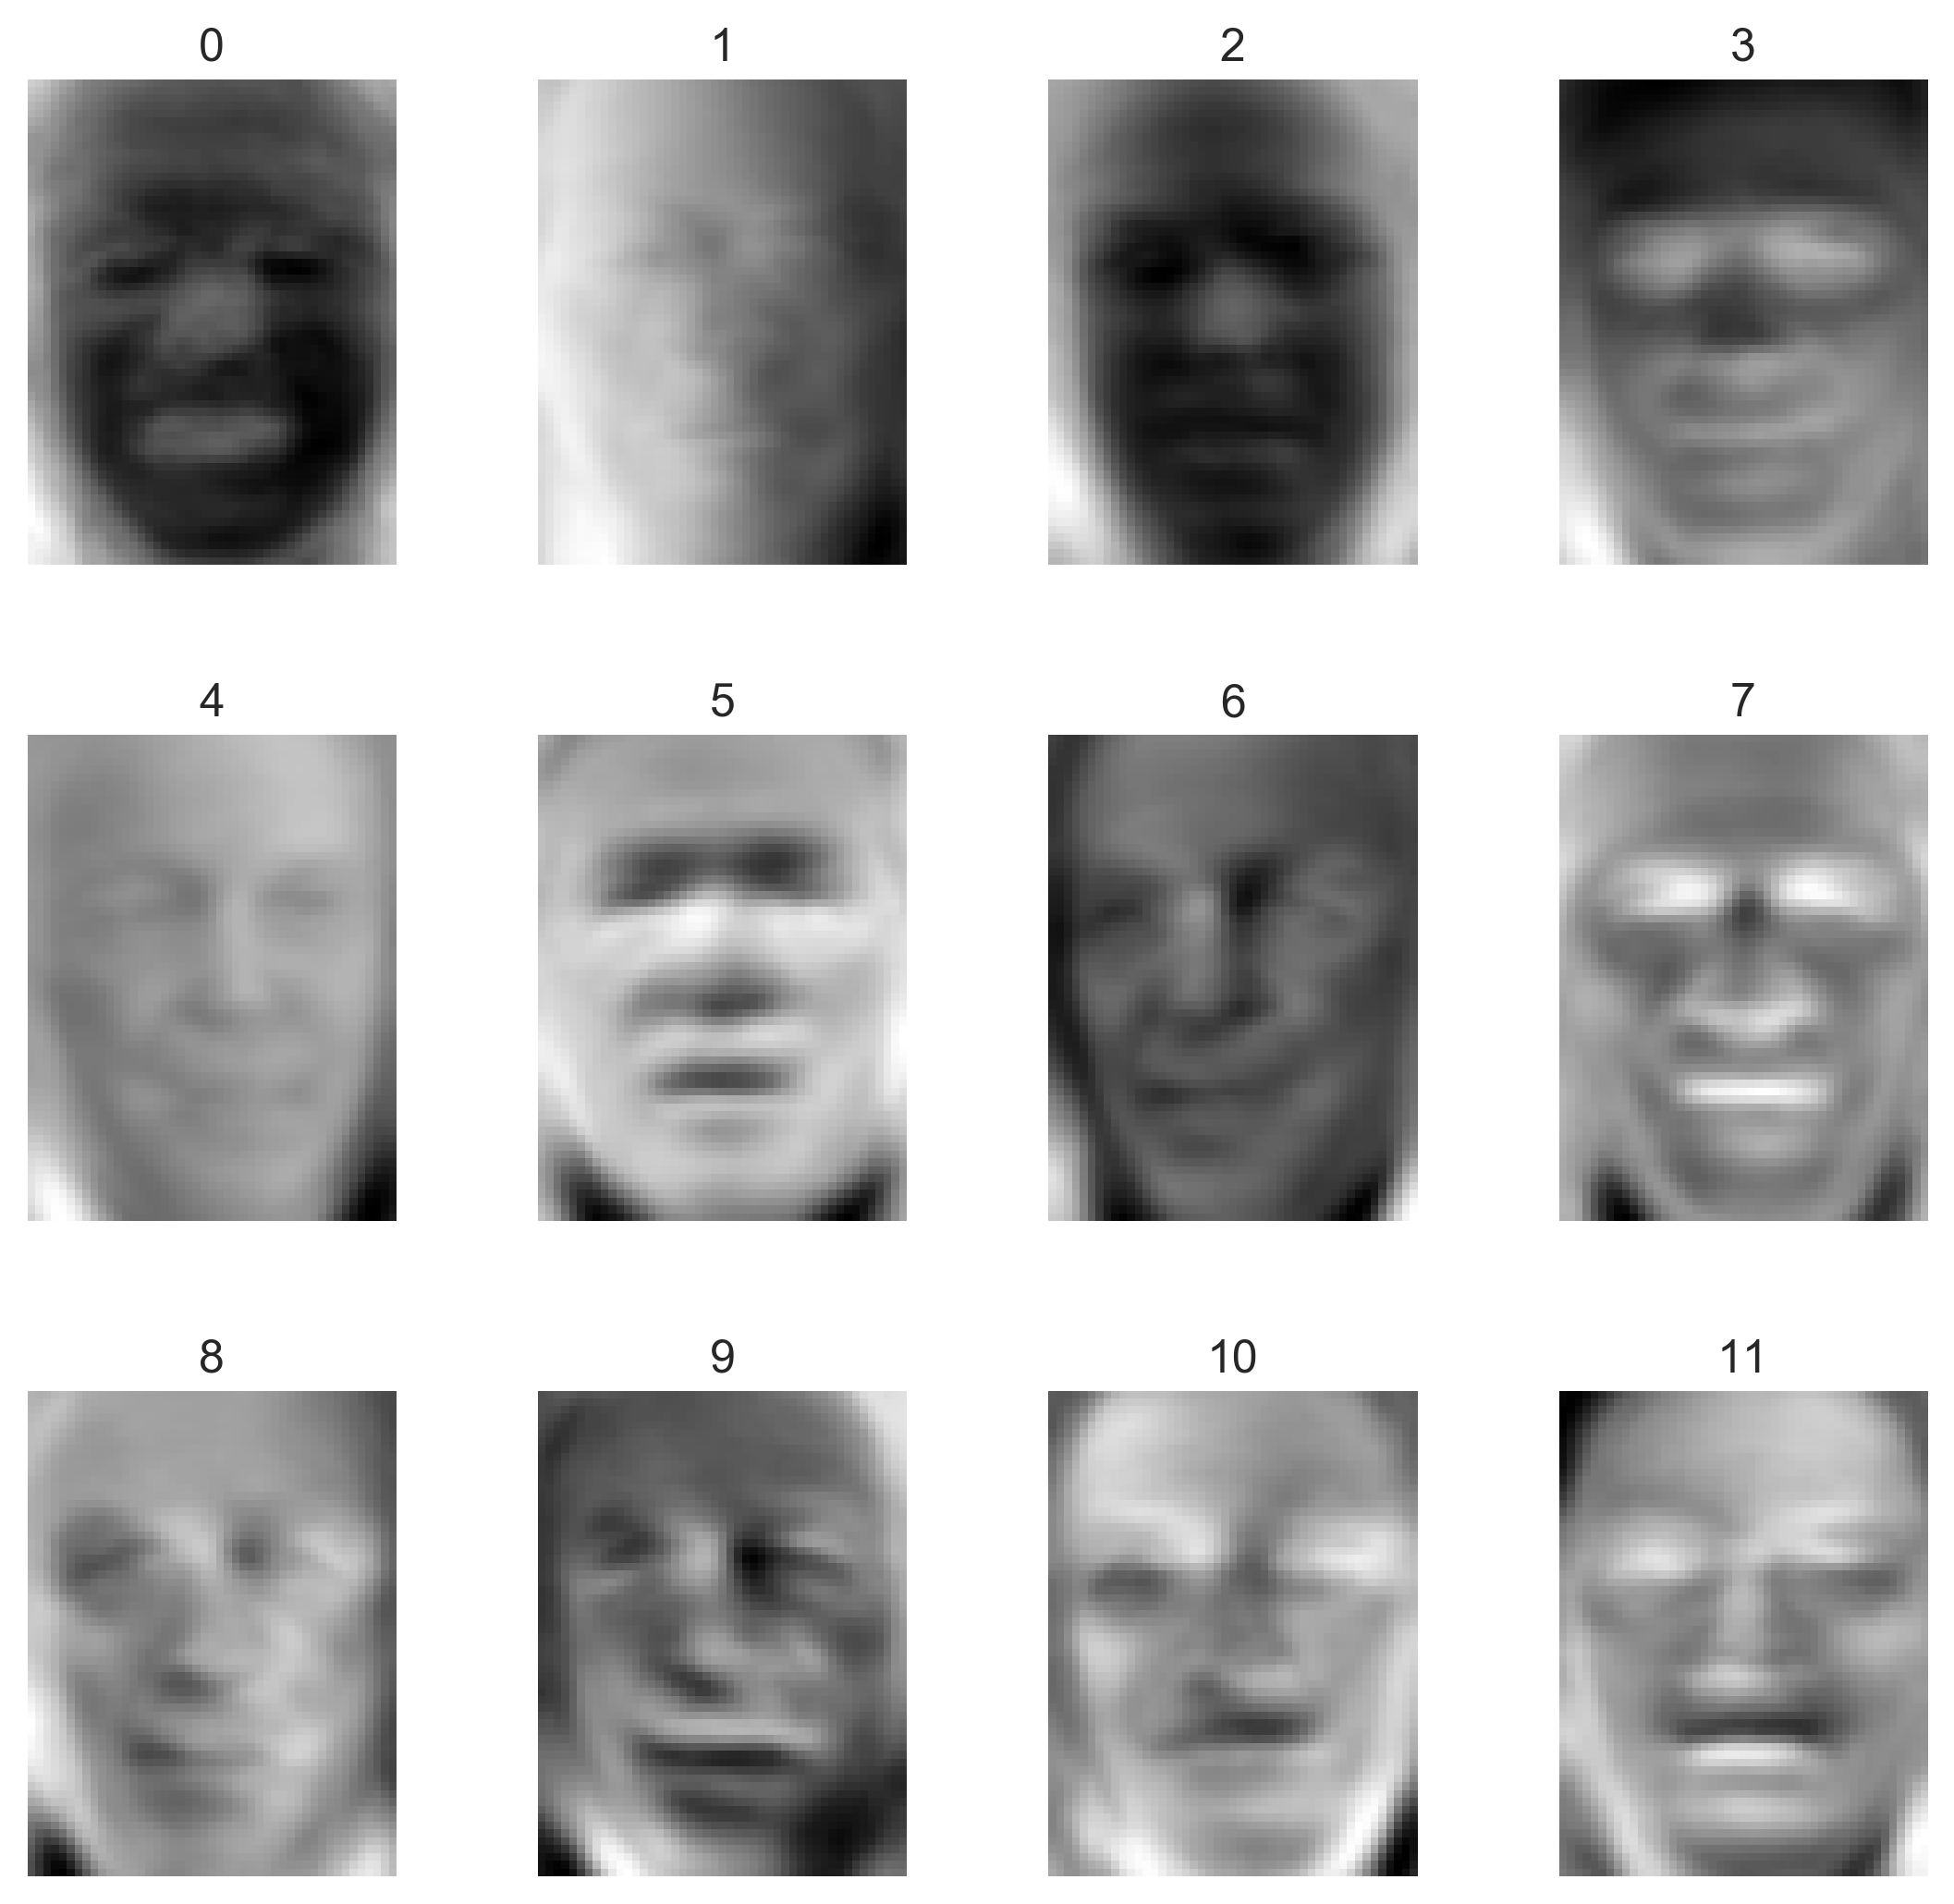

In [12]:
# get the eigenfaces
eigenfaces = pca.components_.reshape((n_components, h, w))

# number them for plot
n_eigenfaces = np.arange(eigenfaces.shape[0])
plot_gallery(eigenfaces, n_eigenfaces, h, w)

So these are some of the components that make the faces in our photographs the most different. Because of their resemblance to faces when arranged in the above shape, and their utility in face recognition, they have the special name of [eigenfaces](https://en.wikipedia.org/wiki/Eigenface). They can be linearly combined to reconstruct images in the original training set.

We are now all set to train our classifier. We will use an SVM with an RBF kernel, which takes two parameters, $C$ and $\gamma$. 

$\gamma$ is the free parameter of the RBF kernel, which is defined as:
$$ K(x ,x') = \exp(-\gamma ||x - x'||^2)$$ where $\gamma = \frac{1}{2\sigma^2}$

A small $\gamma$ means large variance, which increases the influence of a single training example; the inverse is true for large $\gamma$. $C$ is the parameter for the soft margin cost function, and tunes the shape of the decision surface. Low $C$ gives a large minimum margin, and high $C$ gives a low minimum margin. In other words, it represents the trade-off between misclassification and simplicity of the support vector. 

To figure out good parameter values for our data, we will explore a logarithmic grid with basis 10 using GridSearchCV, which computes a score for each pair of parameters and returns the classifier trained with the best value pair. Finally, we will automatically adjust class weights to be inversely proportional to class frequencies by using the "balanced" keyword argument.

In [13]:
C_range = np.logspace(-1, 5, 4)
gamma_range = np.logspace(-3, 0, 4)
param_grid = dict(gamma=gamma_range, C=C_range)
clf = model_selection.GridSearchCV(SVC(kernel='rbf', class_weight='balanced'),
                                   param_grid)
clf = clf.fit(photos_train_pca, labels_train)

We can take a look at the scores for each pair of parameter values. 

The best parameters are {'gamma': 0.01, 'C': 1000.0} with a score of 0.78


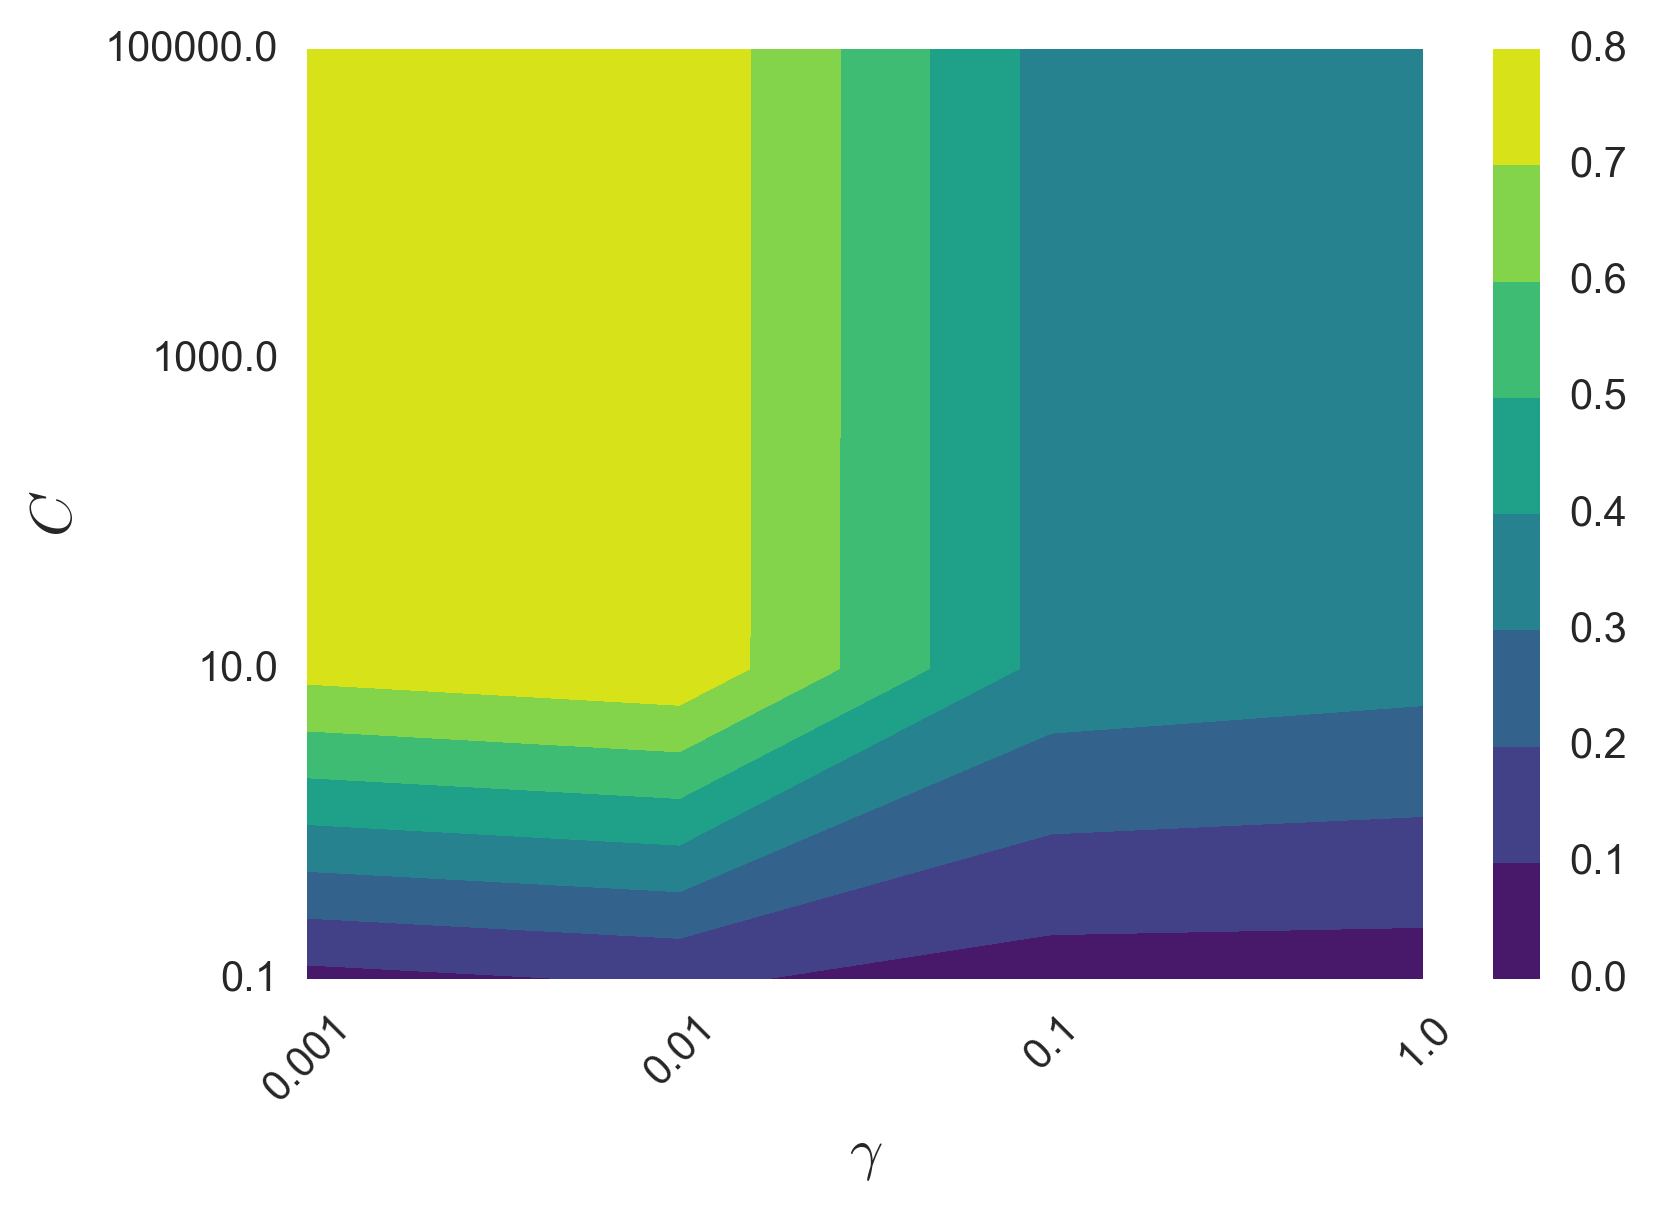

In [15]:
scores = clf.cv_results_['mean_test_score'].reshape(len(C_range), 
                                                    len(gamma_range))

plt.contourf(scores, cmap=plt.cm.viridis)
plt.colorbar()
plt.xticks(np.arange(len(gamma_range)), gamma_range, rotation=45)
plt.yticks(np.arange(len(C_range)), C_range)
plt.ylabel(r'$C$')
plt.xlabel(r'$\gamma$')
print('The best parameters are {0} with a score of {1:.2f}'.format(
        clf.best_params_, clf.best_score_))

We have now trained our SVM to recognize faces. To see how we are doing, we will use the classifier to label our test set, i.e. recognize faces. It is important that we don't test our classifier on the training set, as that will overestimate our predictive ability. We will also show one picture of each predicted person for reference.

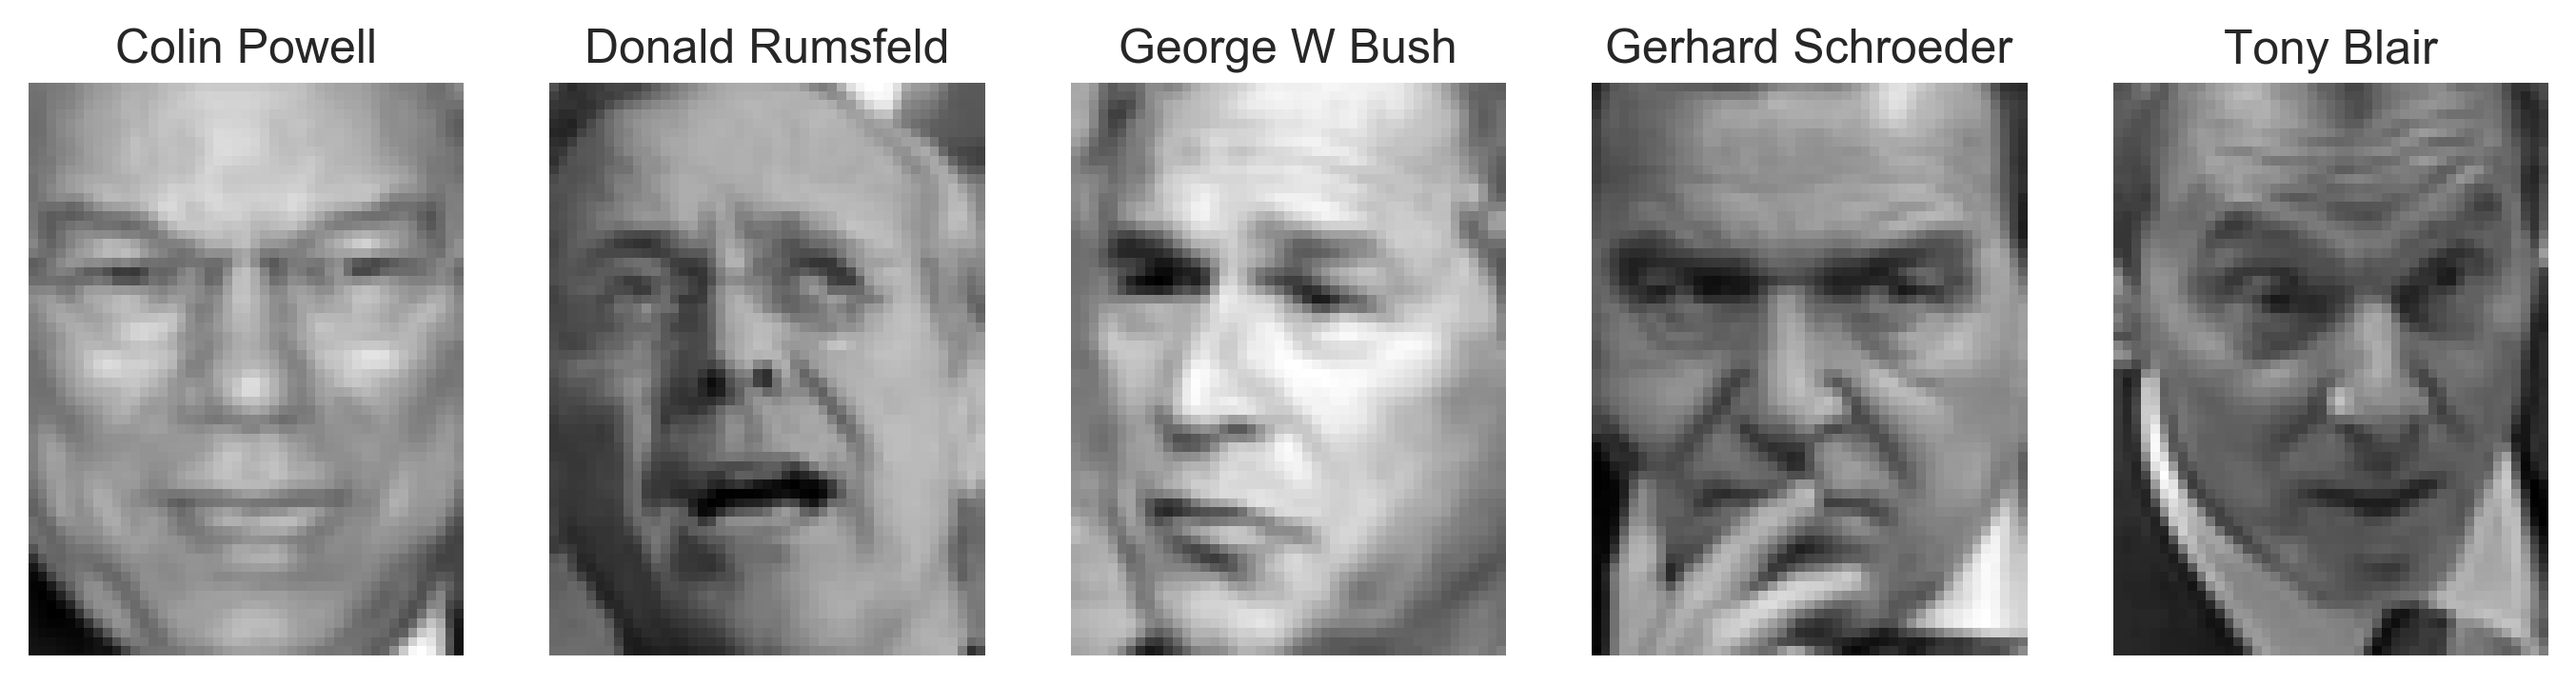

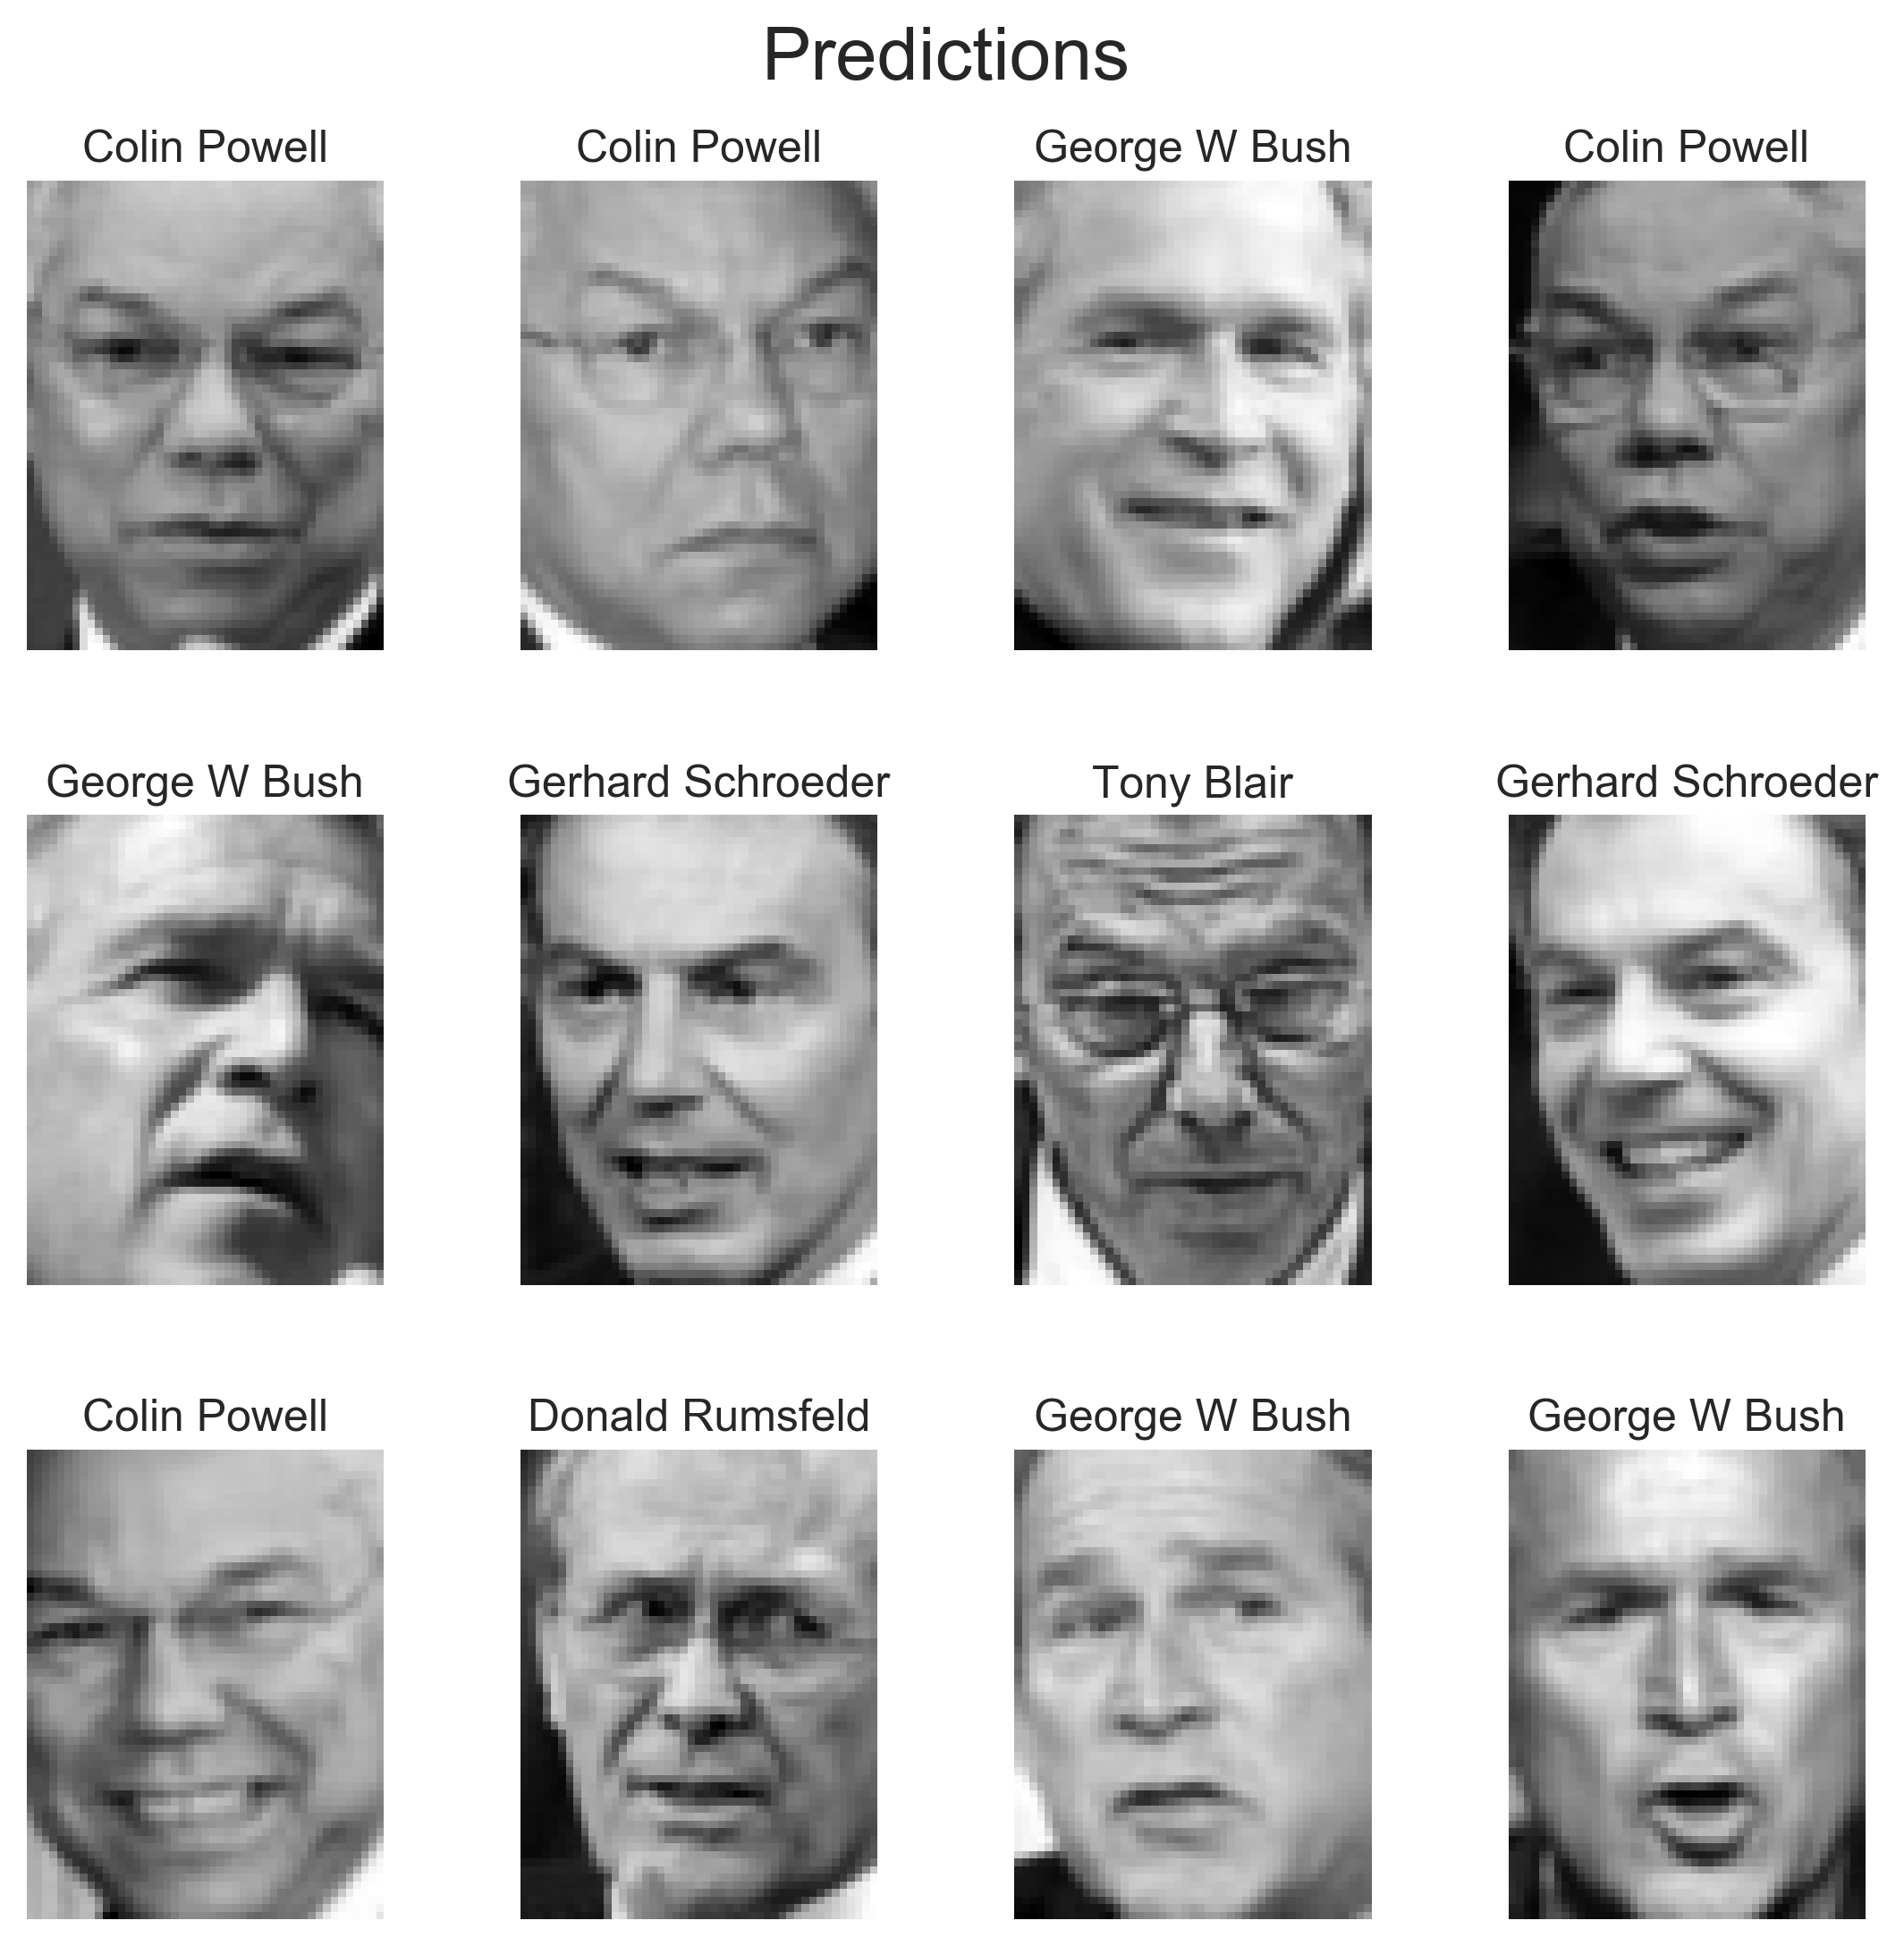

In [17]:
np.random.seed(10)

# predict labels of our test set
labels_pred = clf.predict(photos_test_pca)

# get indices to randomly look at our predictions
r_ind = np.random.choice(photos_test.shape[0], size=12, replace=False)

# get pictures and respective predictions to look at
s_photos = photos_test[r_ind]
labels_pred_sample = labels_pred[r_ind]
names_pred = names[labels_pred_sample]

# get labels and photos of each person for reference
labels_unique = np.unique(labels_pred_sample)
names_true = names[labels_unique]
photos_true = [np.where(lfw_people.target==n)[0][0] for n in labels_unique]
n_col = len(photos_true)

# plot one picture of each person predicted and shown
plot_gallery(lfw_people.images[photos_true], names_true, h, w, 
             n_row=1, n_col=n_col)

# plot predictions
plot_gallery(s_photos, names_pred, h, w, n_row=3, n_col=4, 
             fig_title="Predictions")

We can also be more quantitative and get some numbers using the handy classification report function. 

In [18]:
print(metrics.classification_report(labels_test, labels_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.81      0.72        16
     Colin Powell       0.85      0.88      0.87        66
  Donald Rumsfeld       0.59      0.63      0.61        27
    George W Bush       0.88      0.87      0.87       140
Gerhard Schroeder       0.46      0.46      0.46        24
      Hugo Chavez       0.81      0.76      0.79        17
   Jacques Chirac       0.67      0.40      0.50        10
    Jean Chretien       0.80      0.86      0.83        14
    John Ashcroft       0.74      0.88      0.80        16
Junichiro Koizumi       1.00      0.82      0.90        11
  Serena Williams       0.86      0.67      0.75         9
       Tony Blair       0.74      0.70      0.72        40

      avg / total       0.79      0.79      0.79       390



Precision is the ability not to label as positive a sample that is negative, and recall the ability to find all the positive samples.
The F-score is the weighted (harmonic) mean of the precision and recall. All these values range between [0,1] with 1 being the best value. Finally, support is the number of occurrences correctly labeled in each class.

We could increase our accuracy by increasing the number of components to get a higher explained variance at a speed cost. The training time scales linearly with the number of features. But this is not too bad for having used only a small number of features (out of the original 2914) and only a few lines of code. Again, thanks to the [sklearn](http://scikit-learn.org/stable/) crew. 